<p align="center">
  <br/>
    <a href="https://stabrise.com/scaledp/"><img alt="ScaleDP" src="https://raw.githubusercontent.com/StabRise/ScaleDP/refs/heads/master/images/scaledp.webp" width="376" style="max-width: 100%;"></a>
  <br/>
</p>

<p align="center">
    <i>An Open-Source Library for Processing Documents using AI/ML in Apache Spark.</i>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/object-detection/4.YoloOnnxDetectorBenchmarks.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=blue"></a>
    <a href="https://scaledp.stabrise.com/en/latest/"><img src="https://app.readthedocs.org/projects/scaledp/badge/?version=latest" alt="Documentation Status"/></a>
</p>

# Benchmarking Object Detection using Yolo models in ScaleDP

- Inference using ONNX model for object detection
- CPU: 13th Gen Intel(R) Core(TM) i9-13980HX (32 vCore)
- GPU: NVIDIA GeForce RTX 4090 Laptop

[More details about YoloOnnxDetector](https://scaledp.stabrise.com/en/latest/models/detectors/yolo_onnx_detector.html)


## Check Hardware

In [1]:
import cpuinfo
info = cpuinfo.get_cpu_info()
print("CPU Brand:", info["brand_raw"])
print("Arch:", info["arch"])
print("Bits:", info["bits"])
print("Logical Cores:", info.get("count", "N/A"))

CPU Brand: 13th Gen Intel(R) Core(TM) i9-13980HX
Arch: X86_64
Bits: 64
Logical Cores: 32


## Installation

Required Java 8

### Automatically install Java 8 if run on Google Colab

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
import os
import sys

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
!pip install scaledp

## Prepare model for run in ScaleDP

### Install ultralytics

In [ ]:
# Need only for export model
!pip install ultralytics

### Load model and get labels

In [2]:
from ultralytics import YOLO

# Load model (weights can be custom or pretrained)
model = YOLO("yolo11n.pt")  # or yolov9n.pt

label_list = list(model.names.values())
print(label_list)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


### Export model to the ONNX format

In [2]:
model.export(format="onnx")

Ultralytics 8.3.226 🚀 Python-3.11.11 torch-2.6.0+cpu CPU (13th Gen Intel Core(TM) i9-13980HX)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.73...
ONNX: export success ✅ 0.9s, saved as 'yolo11n.onnx' (10.2 MB)

Export complete (1.1s)
Results saved to /home/mykola/PycharmProjects/scaledp/tutorials/object-detection
Predict:         yolo predict task=detect model=yolo11n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolo11n.onnx imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'yolo11n.onnx'

### Check that model is exported

In [16]:
!ls yolo*

yolo11n.onnx  yolo11n.pt


## Start Spark Session with ScaleDP and Spark PDF Data Source

In [8]:
from scaledp import *

spark = ScaleDPSession(with_spark_pdf=True)
spark

## Read PDF file to the DataFrame

Download the file

In [ ]:
!wget https://raw.githubusercontent.com/StabRise/ScaleDP-Tutorials/master/data/pdfs/samples_1k.pdf -O samples_1k.pdf

Check file size

In [5]:
!du -h ./samples_1k.pdf

95M	./samples_1k.pdf


In [9]:
%%time
pdf_example = './samples_1k.pdf'

# Alternative reader - "pdfBox"
# For use 'GS' reader you need to have installed 'ghostscript' in your system.
df = spark.read.format("pdf") \
    .option("pagePerPartition", "20") \
    .option("reader", "gs") \
    .load(pdf_example)

df.select("filename", "page_number", "partition_number").show(5)

+--------------+-----------+----------------+
|      filename|page_number|partition_number|
+--------------+-----------+----------------+
|samples_1k.pdf|          1|               0|
|samples_1k.pdf|          2|               0|
|samples_1k.pdf|          3|               0|
|samples_1k.pdf|          4|               0|
|samples_1k.pdf|          5|               0|
+--------------+-----------+----------------+
only showing top 5 rows

CPU times: user 1.83 ms, sys: 1.13 ms, total: 2.96 ms
Wall time: 2.17 s


## Check number of pages in pdf file

In [5]:
%%time
df.count()

CPU times: user 1.02 ms, sys: 3 μs, total: 1.02 ms
Wall time: 794 ms


1000

## Show PDF File as image

Image#:,0
Path:,samples_1k.pdf
Size:,0 x 0 px
Resolution:,300 dpi

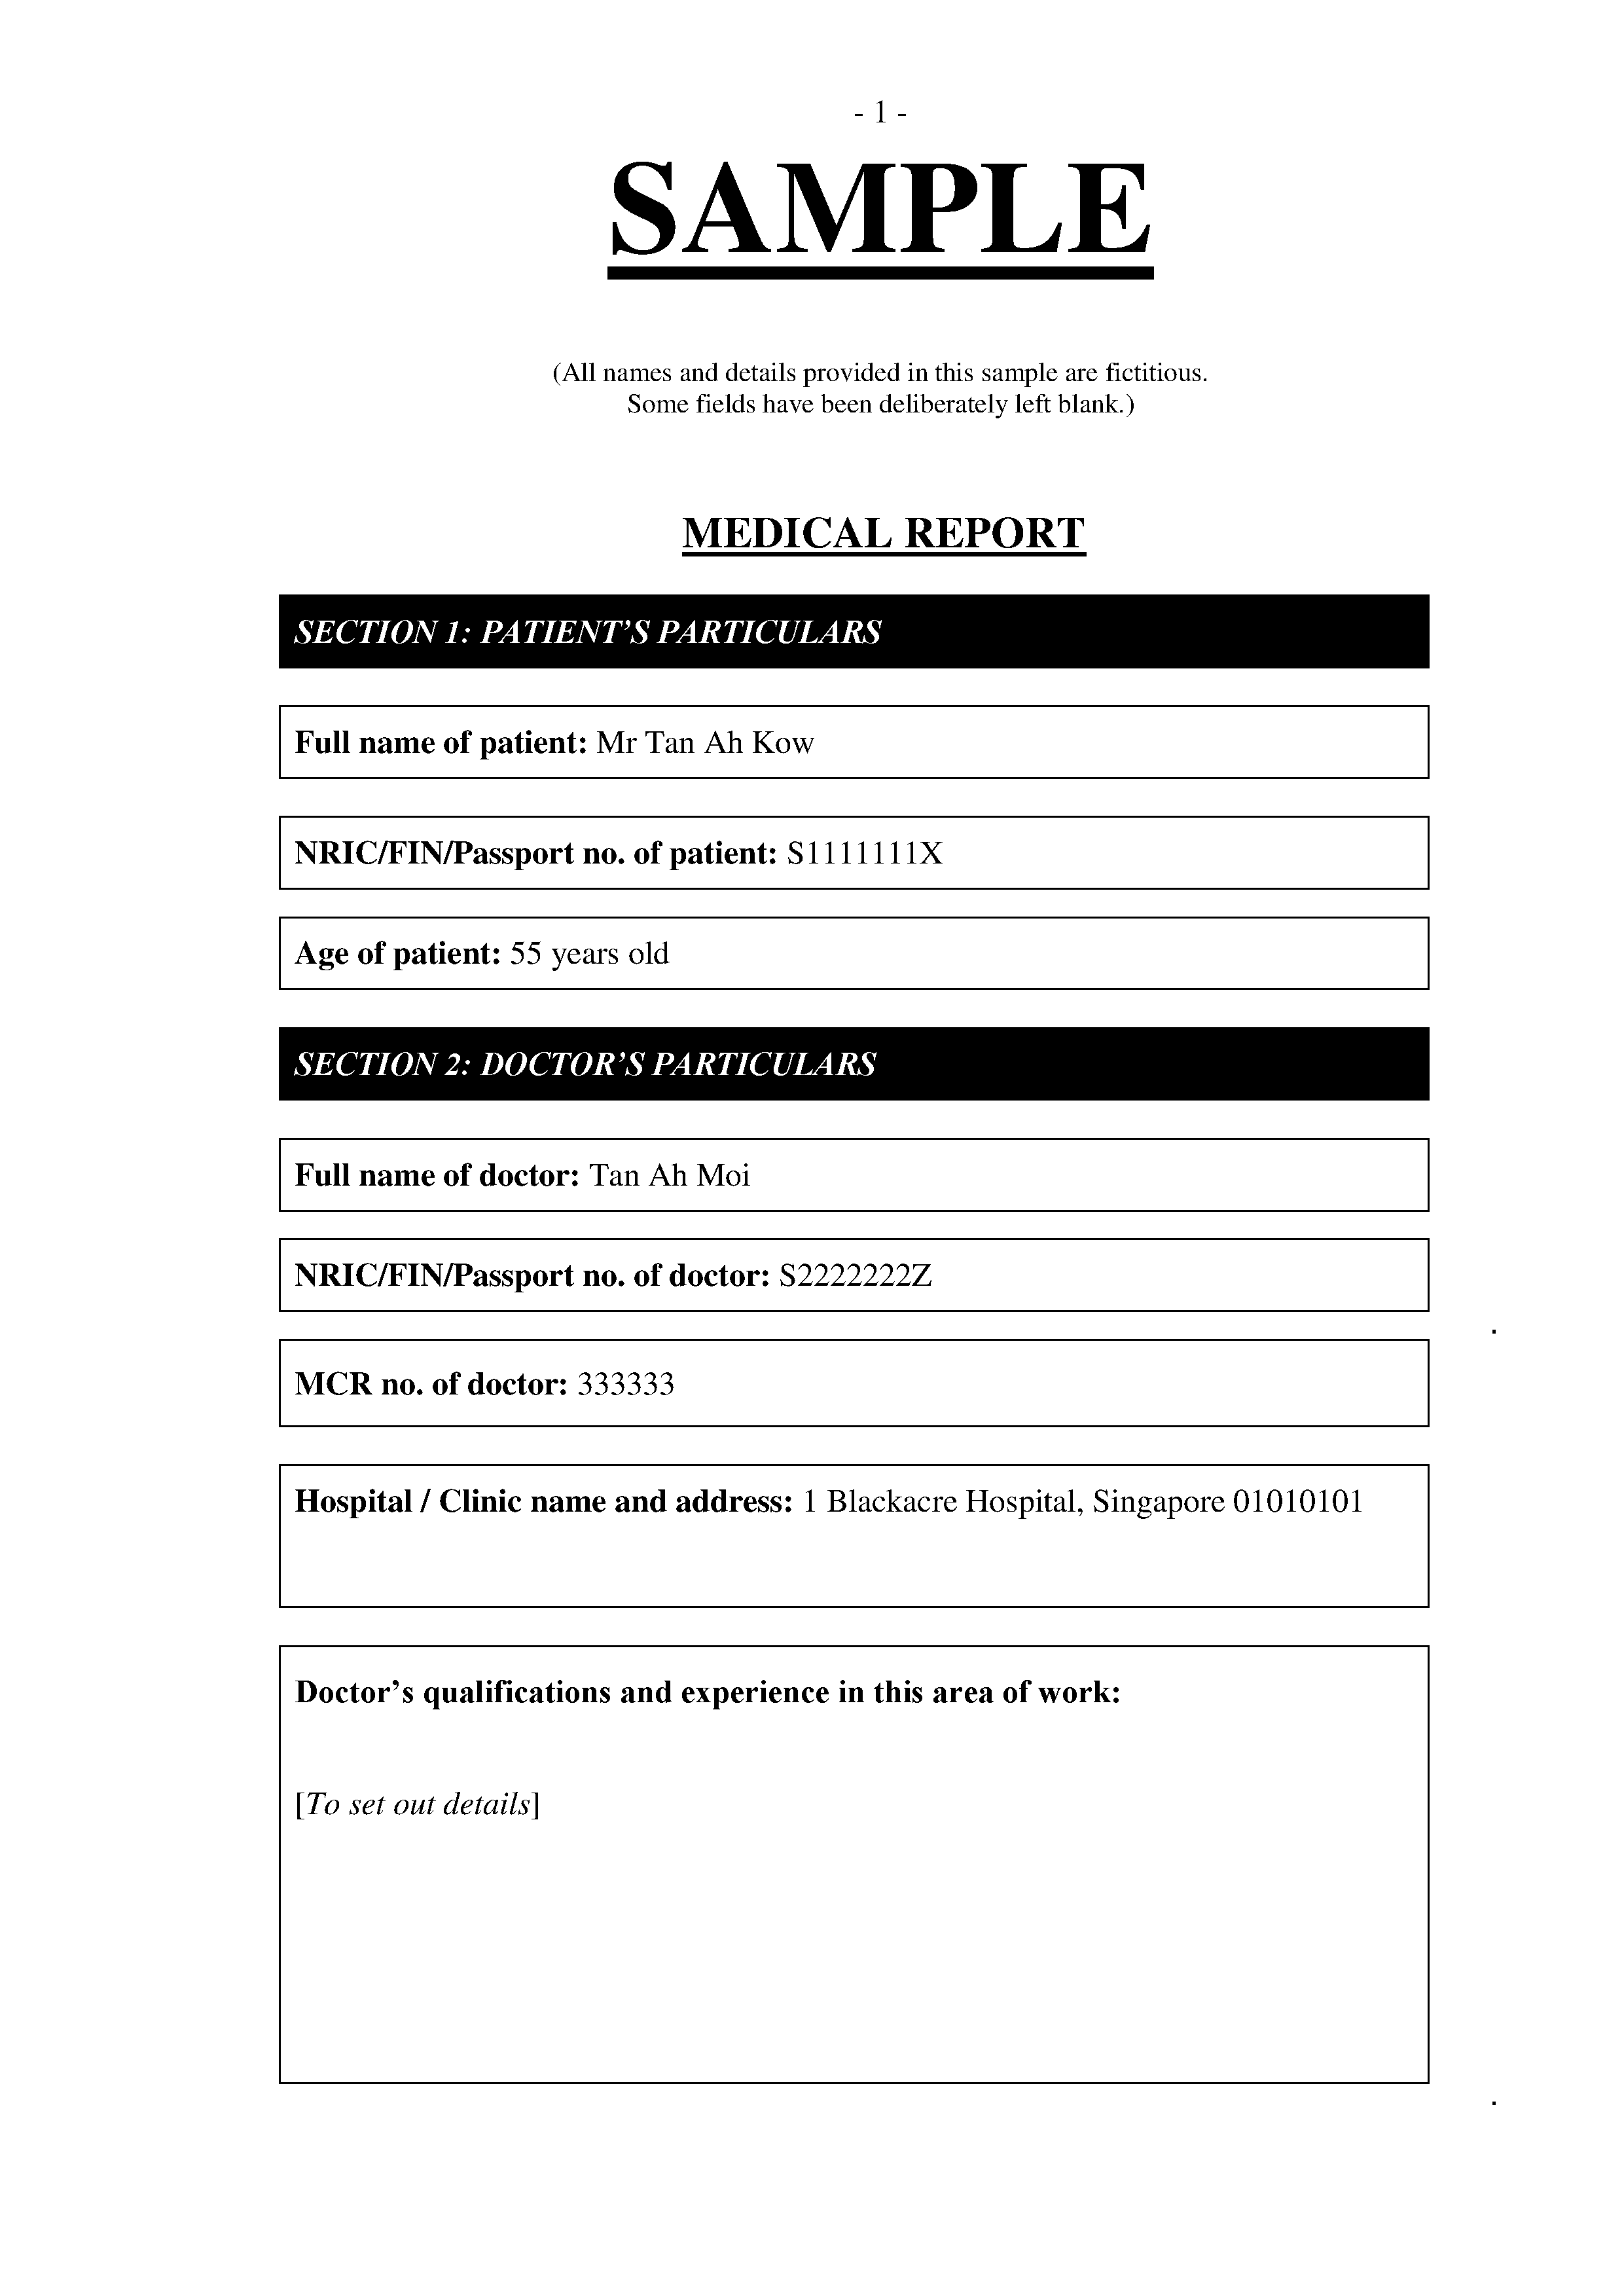

CPU times: user 15.3 ms, sys: 5.13 ms, total: 20.4 ms
Wall time: 344 ms


In [44]:
%%time
df.show_image(limit=1)

## Define pipeline with yolo YoloOnnxDetector

In [5]:
def get_pipeline(
    device=Device.CPU,
    numPartitions=0
):
    return PipelineModel(stages=[
    YoloOnnxDetector(
        keepInputData=False,
        partitionMap=True,
        numPartitions=numPartitions,
        model="yolo11n.onnx",
        device=device,
        scoreThreshold=0.6,
        labels=label_list
    )
])

## Run pipeline on CPU

In [9]:
results = get_pipeline().transform(df)

In [11]:
%%time
data = results.select("boxes").limit(1000).collect()

CPU times: user 126 ms, sys: 6.38 ms, total: 132 ms
Wall time: 1min 14s


## Run pipeline on GPU

In [ ]:
results_gpu = get_pipeline(device=Device.CUDA).transform(df)

In [ ]:
%%time
data = results_gpu.select("boxes").limit(1000).collect()

## Run only detection with cached images in DataFrame

In [9]:
df_cached = df.select("path", "image").cache()
results = get_pipeline().transform(df_cached)

### On CPU

In [11]:
%%time
data = results.select("boxes").limit(1000).collect()

CPU times: user 67.6 ms, sys: 58.7 ms, total: 126 ms
Wall time: 1min 9s


## On GPU

In [10]:
%%time
results_gpu_cached = get_pipeline(device=Device.CUDA).transform(df_cached)
data = results_gpu_cached.select("boxes").limit(1000).collect()

CPU times: user 66.8 ms, sys: 26 ms, total: 92.8 ms
Wall time: 14.7 s


## Benchmark results

| Pages in Partition | Device | Reader | Time for 1000 pages, s | Per 1 page, s | Notes      |
|--------------------|--------|--------|------------------------|---------------|------------|
| 100                | CPU    | PdfBox | 93                     | 0.093         |            |
| 50                 | CPU    | PdfBox | 77                     | 0.077         |            |
| 20                 | CPU    | GS     | 56                     | 0.056         | Only Yolo  |
| 20                 | GPU    | GS     | 27.2                   | 0.0272        |            |
| 20                 | GPU    | GS     | 14.7                   | 0.0147        | Only Yolo  |


## Run Yolo directly on the same image

In [23]:
image = df.select("image").limit(1).collect()[0].image.data
with open("image.png", "wb") as f:
    f.write(image)

## CPU Inference

In [29]:
%%time
res = model.predict("image.png")


image 1/1 /home/mykola/PycharmProjects/scaledp/tutorials/object-detection/image.png: 640x480 (no detections), 30.7ms
Speed: 1.3ms preprocess, 30.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)
CPU times: user 275 ms, sys: 891 μs, total: 276 ms
Wall time: 49.4 ms
